# $\textbf{Part 2. Predicting LFSR States Using Feedforward Neural Networks}$
$\text{Author: Ryan Burns}$



# $\quad\quad\quad\textit{Pardon my appearance, I am currently under development.}$



#### $\textbf{Linear Feedback Shift Registers (LFSRs)}$
$\text{For background on LFSRs and maximum-length }m\text{-sequences, visit: }\textit{https://en.wikipedia.org/wiki/Linear-feedback_shift_register.}$
$\text{It is assumed that a finite list of primitive polynomial coefficients (stored as hex values) are available for the polynomial degree specified below}$
$\text{via a locally stored file with name <degree>.txt. For degree-10 polynomials, for example, the corresponding primitive polynomial coefficients}$
$\text{would have file name 10.txt. LFSRs are built for each polynomial, each yielding a pseudorandom binary sequence of length/period }2^{\text{degree}}-1.$


### $\textbf{Import Dependencies}$

In [1]:
# System imports
from os import environ
from time import time

# So numpy and Tensorflow can cooperate
environ['KMP_DUPLICATE_LIB_OK']='True'

# Numpy imports
from numpy import array, matmul, transpose, squeeze, hstack, vstack, dstack
from numpy import expand_dims, zeros, shape, linspace, arange, max, roll

# Galois / LFSR utilities
from galois_tools import *
from m_sequence_viz import *
from lfsr_network_viz import *
from ml_utils import *

# Plotting functionality
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

# Tensorflow/Keras functionality
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model;
from tensorflow.keras.optimizers import RMSprop;
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives;

### $\textbf{Plotting Macro (Requires IPython)}$

In [2]:
%matplotlib notebook

### $\textbf{Specify LFSR & Neural Net Parameters}$

In [3]:
###########################
# Specify LFSR parameters #
###########################

# Primitive polynomial degree
deg = 10 # (= number of bits)

# Length of m-sequence generated
M = 2**deg - 1 # (bits)

# Initial state of register
seed = 1 # (decimal form)

###############################
# Network training parameters #
###############################

# Number of RMSprop training epochs
N_epoch = 20000

# Batch size equal to m-sequence length
N_batch = 2**deg - 1

# Learning rate for RMSprop
learning_rate = 0.001

#########################
# Behavioral parameters #
#########################

# Turn ON/OFF observed vs. predicted mask plot
plot_prediction_masks = True

# Turn ON/OFF tapped vs. normal LFSR state observations
enable_tapped_register_obs = False

# Turn ON/OFF visualzation of metrics vs. training epoch
plot_metrics_versus_epoch = True

### $\textbf{Load Primitive Polynomial Coefficients of Specified Degree Over }GF(2)$

In [4]:
#############################################################
# Load coeff. of primitive polynomials over GF(2) from file #
#############################################################

# Read list of primitive polynomial coefficients for definition
# of the linear feedback shift registers yielding m-sequences
coeff_catalog = read_polynomials_from_file(deg=deg,
    path='./primitive_polynomials/')

# Number of polynomials in catalog
N_polynomials = len(coeff_catalog)

###########################################################
# Generate linear feedback shift registers w/ polynomials #
###########################################################

# Define a bank of LFSRs - 1 per polynomial in the catalog
LFSRs = [LFSR(mask=eval(hex2bin(coeff_catalog[n], nbits=deg)), 
    seed=seed, order=deg, register_id=str(n)) 
    for n in range(len(coeff_catalog))]

### $\textbf{Generate Sequence of LFSR State Transitions }\{n, n + 1\}\textbf{ and Primitive Polynomial Labels}$

<IPython.core.display.Javascript object>


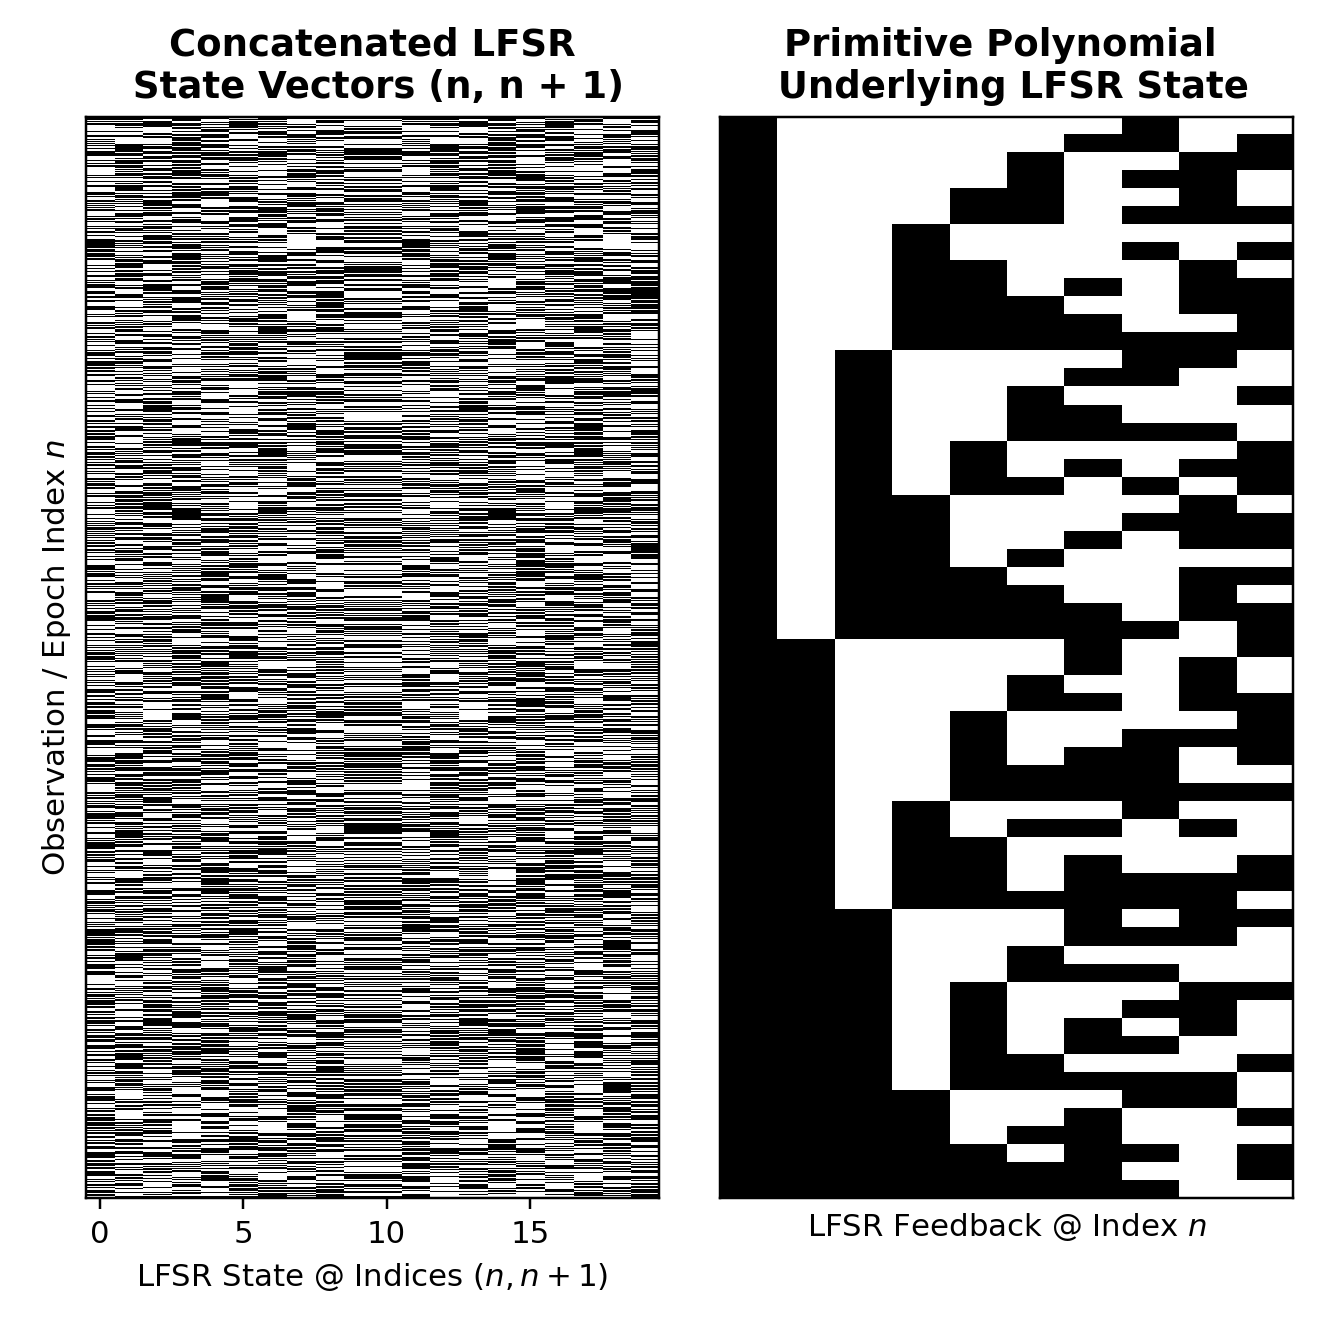

In [5]:
#################################
# Generate labeled observations #
#################################

# Generate LFSR transition (n, n + 1) obs & polynomial labels
X, Y = labeled_state_transition_obs(LFSRs, coeff_catalog)

##################################
# Visualize labeled observations #
##################################

# Plot the labeled observations...
if plot_prediction_masks:
    
    # Plot the state progression & recursion polynomial progression
    plot_polynomial_prediction_masks(X, Y) # (flattened as binary masks)